In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from imblearn.over_sampling import SMOTE

In [2]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [3]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [4]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


# Background

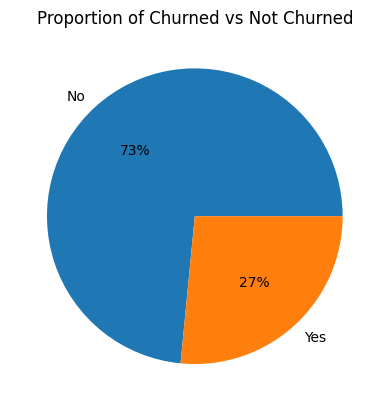

In [5]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [6]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Distribution

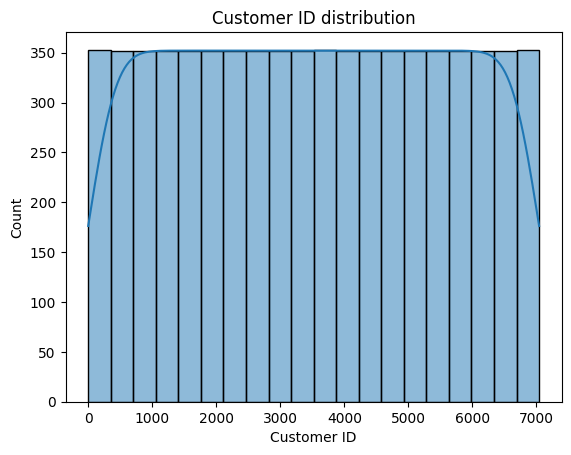

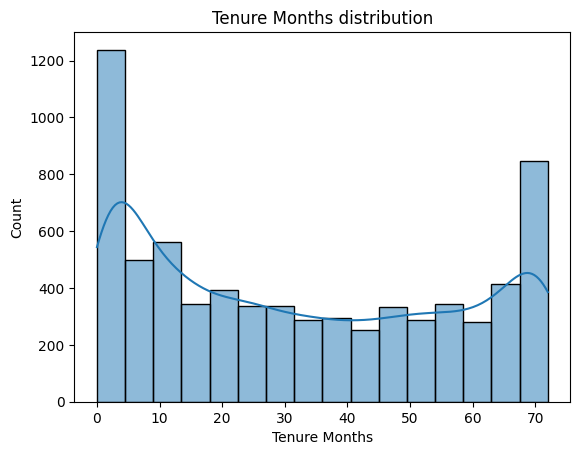

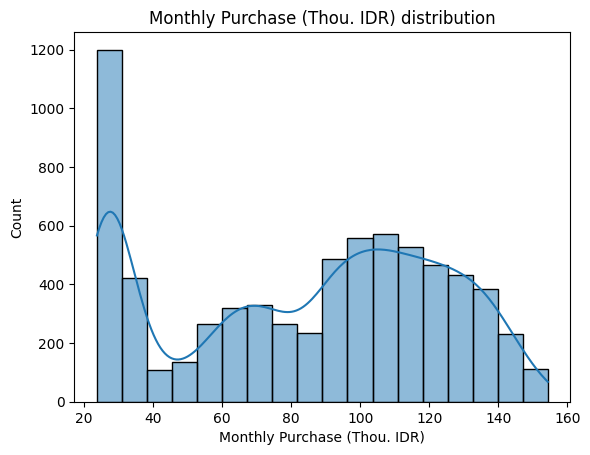

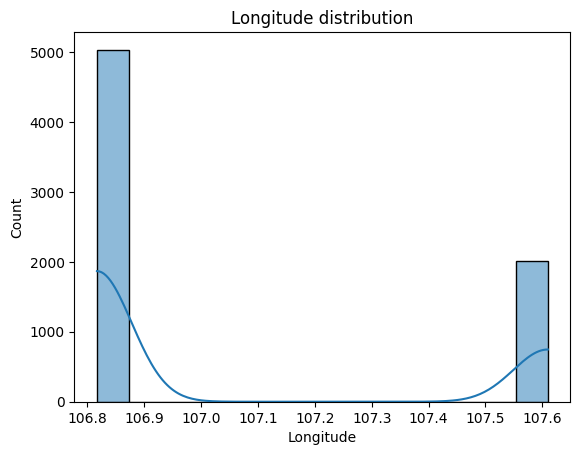

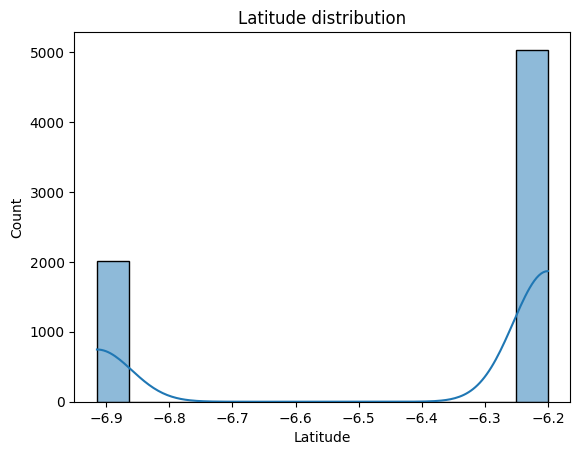

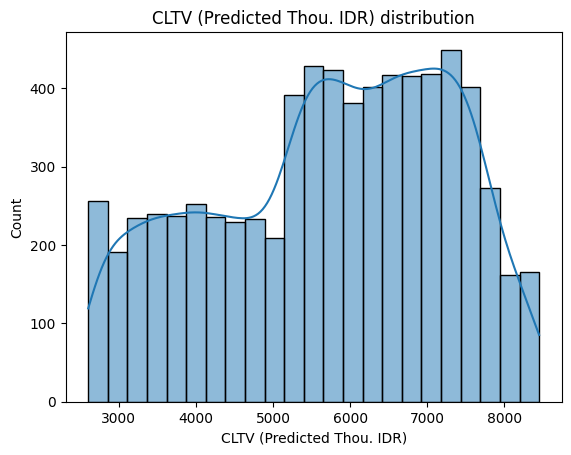

In [7]:
for c in df.select_dtypes(include=[int, float]):
    sns.histplot(df[c], kde=True)
    plt.title(f"{c} distribution")
    plt.show()

## Device Class

[Text(0.5, 0, 'Churn Label'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Device Class vs Churn Label')]

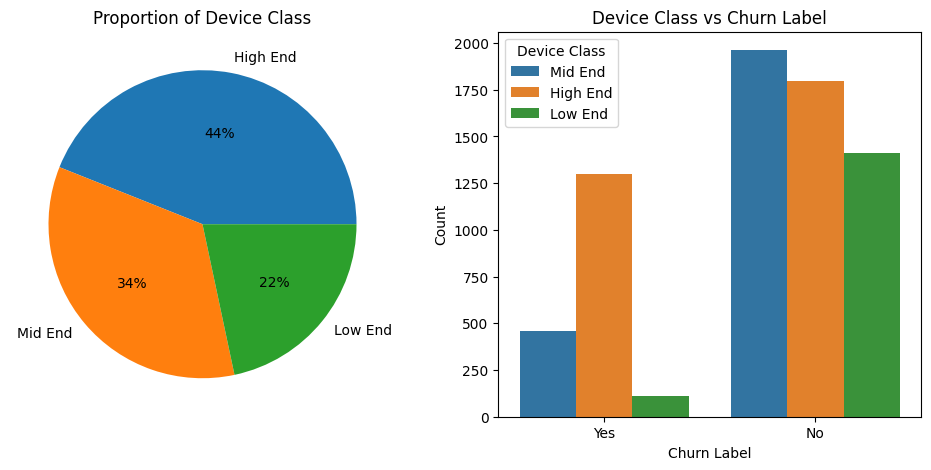

In [8]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

## Location

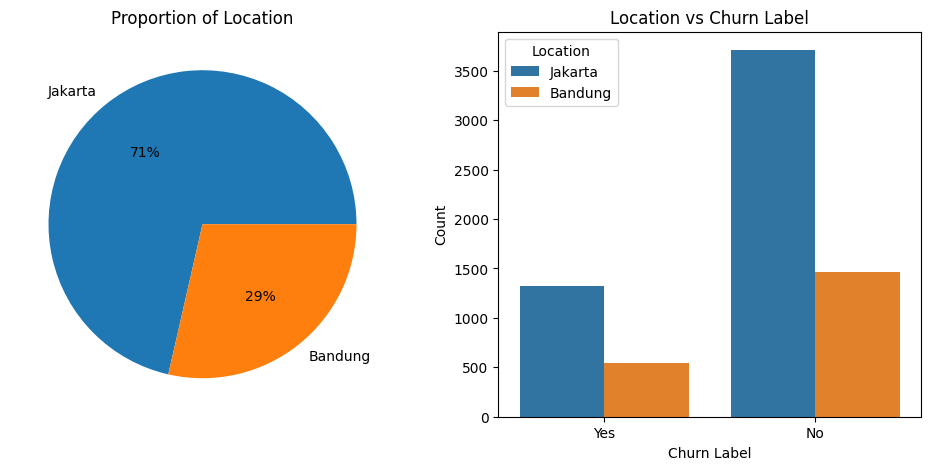

In [9]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [10]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [11]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

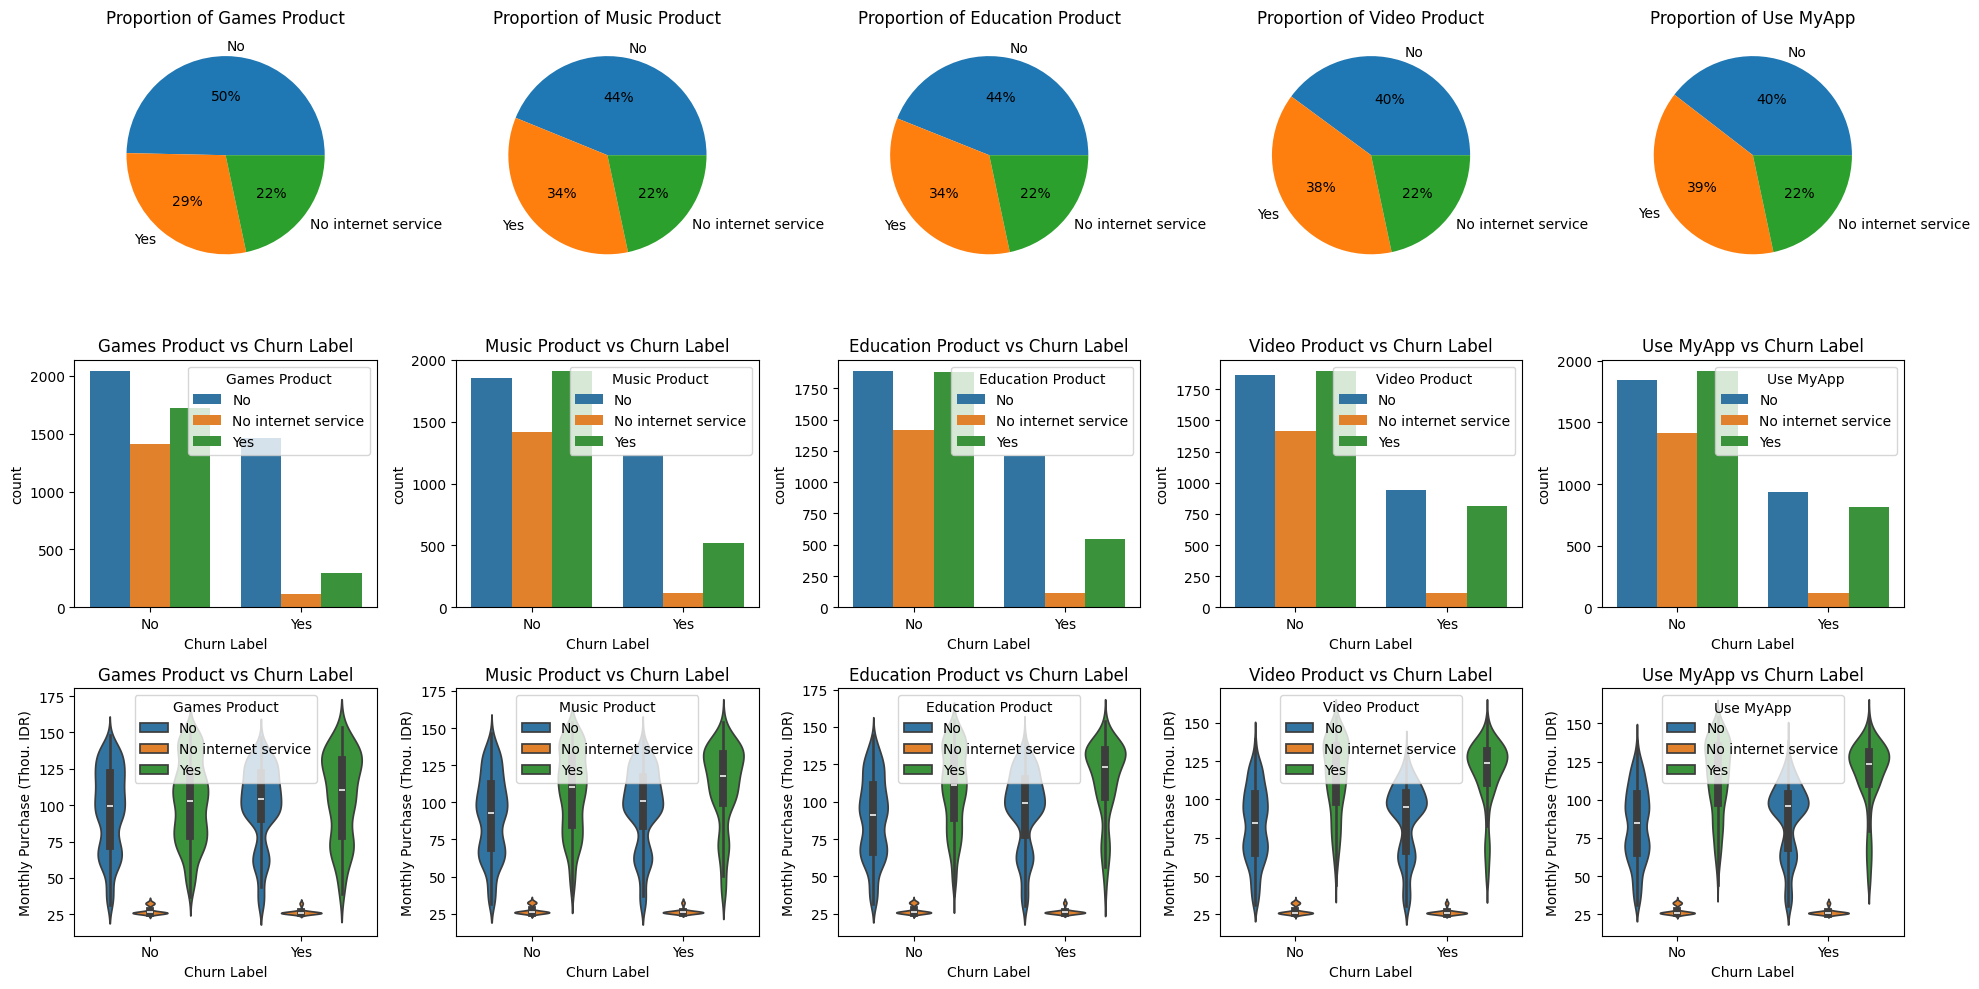

In [12]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

## Payment Method

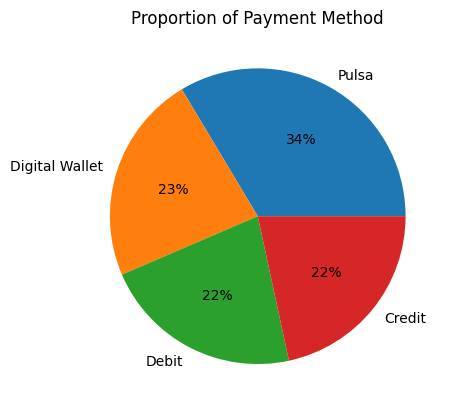

In [13]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

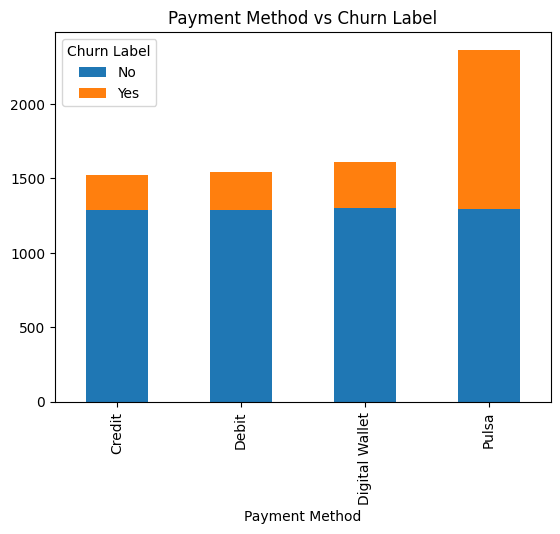

In [14]:
plot_df = df.pivot_table(index="Payment Method", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

In [15]:
churn_payment_method = df.pivot_table(index="Payment Method", columns="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Churn,0,1
Payment Method,,
Credit,0.249324,0.124131
Debit,0.248550,0.138042
Digital Wallet,0.252029,0.164794
Pulsa,0.250097,0.573034


1. Users buy using pulsa has high change of churn

## Tenure Months

In [16]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


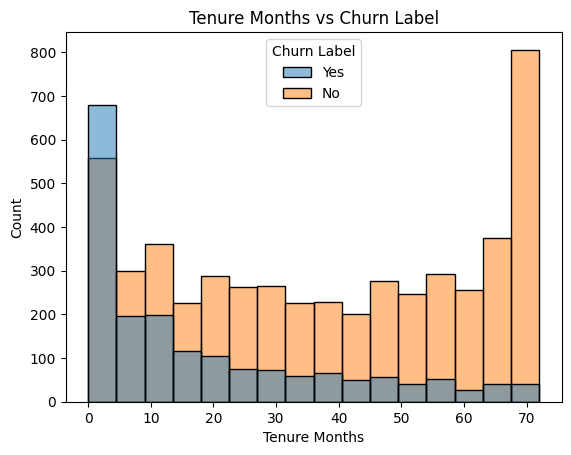

In [17]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

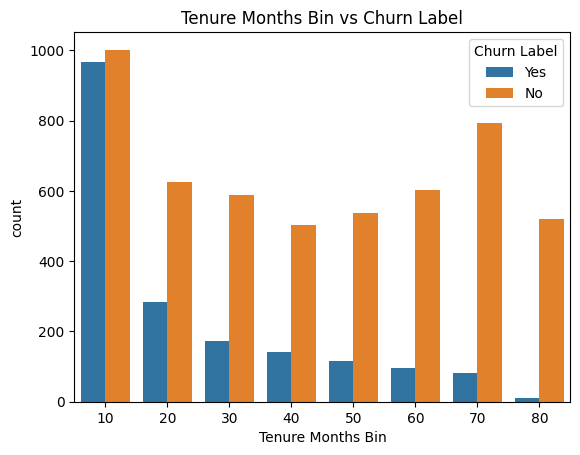

In [18]:
df['Tenure Months Bin'] = pd.cut(df['Tenure Months'], bins=[-1, 10, 20, 30, 40, 50, 60, 70, 80], labels=[10, 20, 30, 40, 50, 60, 70, 80])
sns.countplot(data=df, x='Tenure Months Bin', hue='Churn Label')
plt.title("Tenure Months Bin vs Churn Label")
plt.show()

User with low tenure has a high change of churning especially from 0 to 10 months tenure

## Monthly Purchase

In [19]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

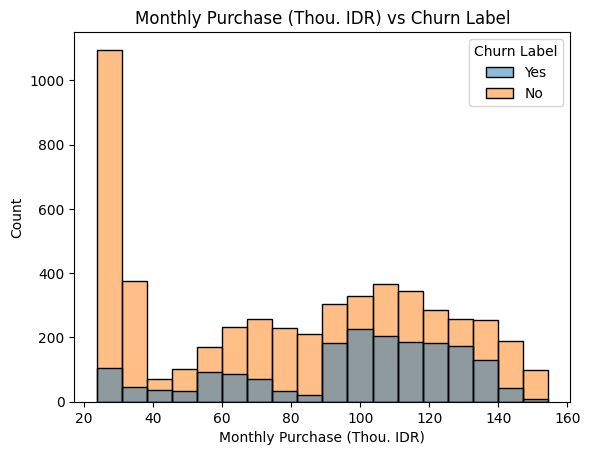

In [20]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

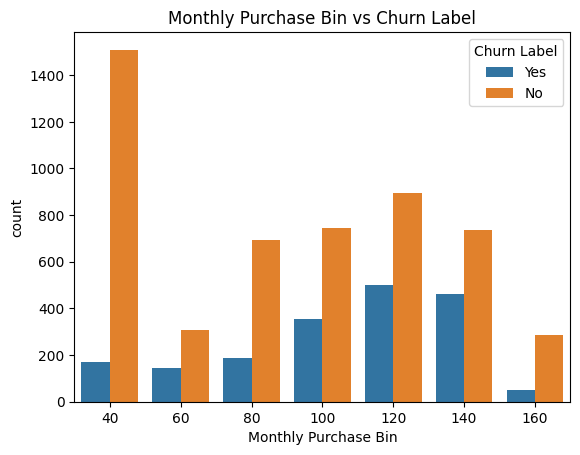

In [21]:
df['Monthly Purchase Bin'] = pd.cut(df['Monthly Purchase (Thou. IDR)'], bins=[20, 40, 60, 80, 100, 120, 140, 160], labels=[40, 60, 80, 100, 120, 140, 160])
sns.countplot(data=df, x='Monthly Purchase Bin', hue='Churn Label')
plt.title("Monthly Purchase Bin vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 100,000.00 - Rp 120,000.00 a month.

## CLTV

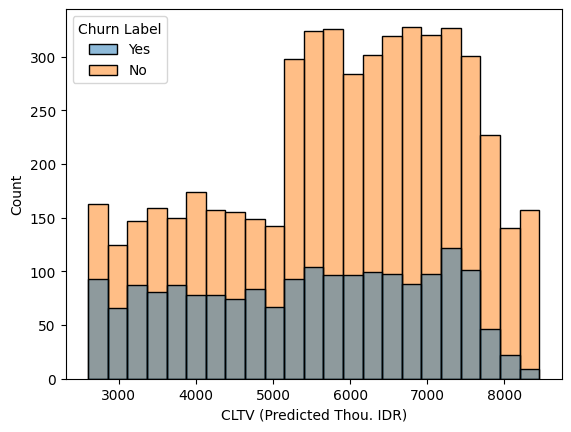

In [22]:
sns.histplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature. The CLTV above Rp 7,500,000 has a high chance of churning.

## Call Center
Check whether the customer uses the call center service

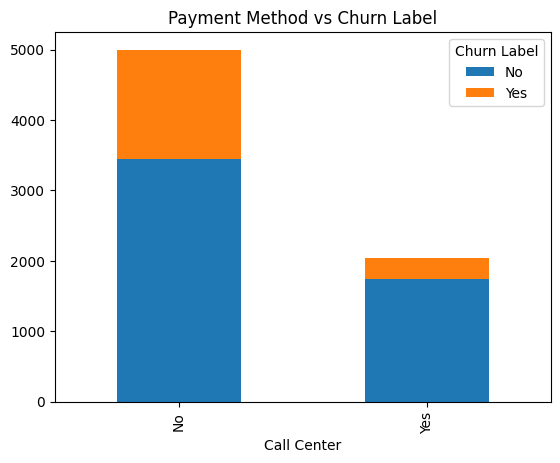

In [23]:
plot_df = df.pivot_table(index="Call Center", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

## Total Purchase

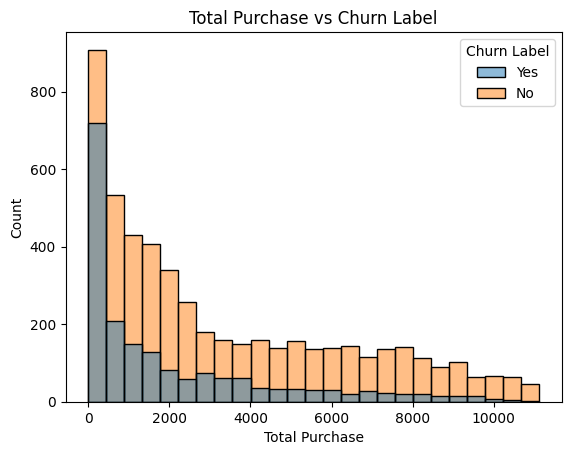

In [24]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

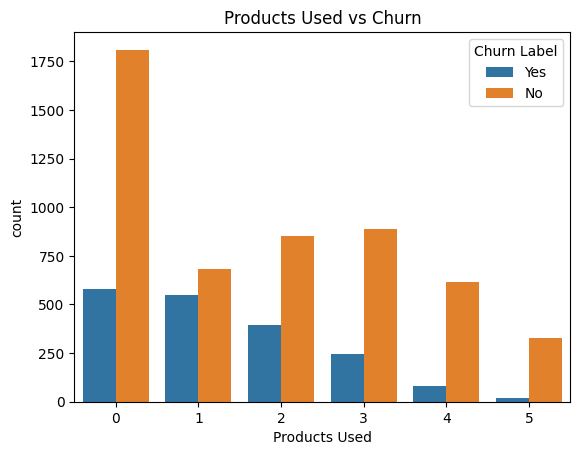

In [25]:
def uses_internet_for_product(data):
    if data == "Yes": return 1
    return 0

# Total Product Used
df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Call Center'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df, x="Products Used", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show()

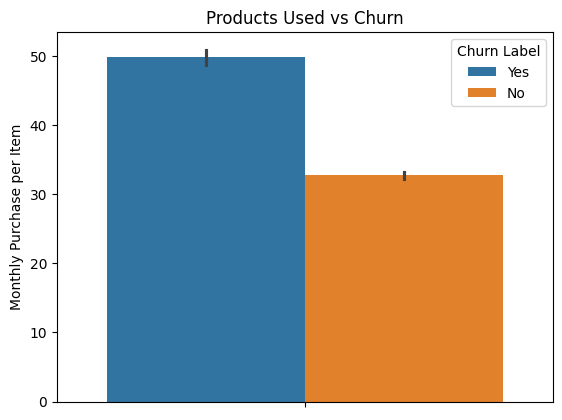

In [26]:
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

sns.barplot(data=df, y="Monthly Purchase per Item", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show()

User that pay more and use little of the product services has a high chance of churning

## Correlation Map

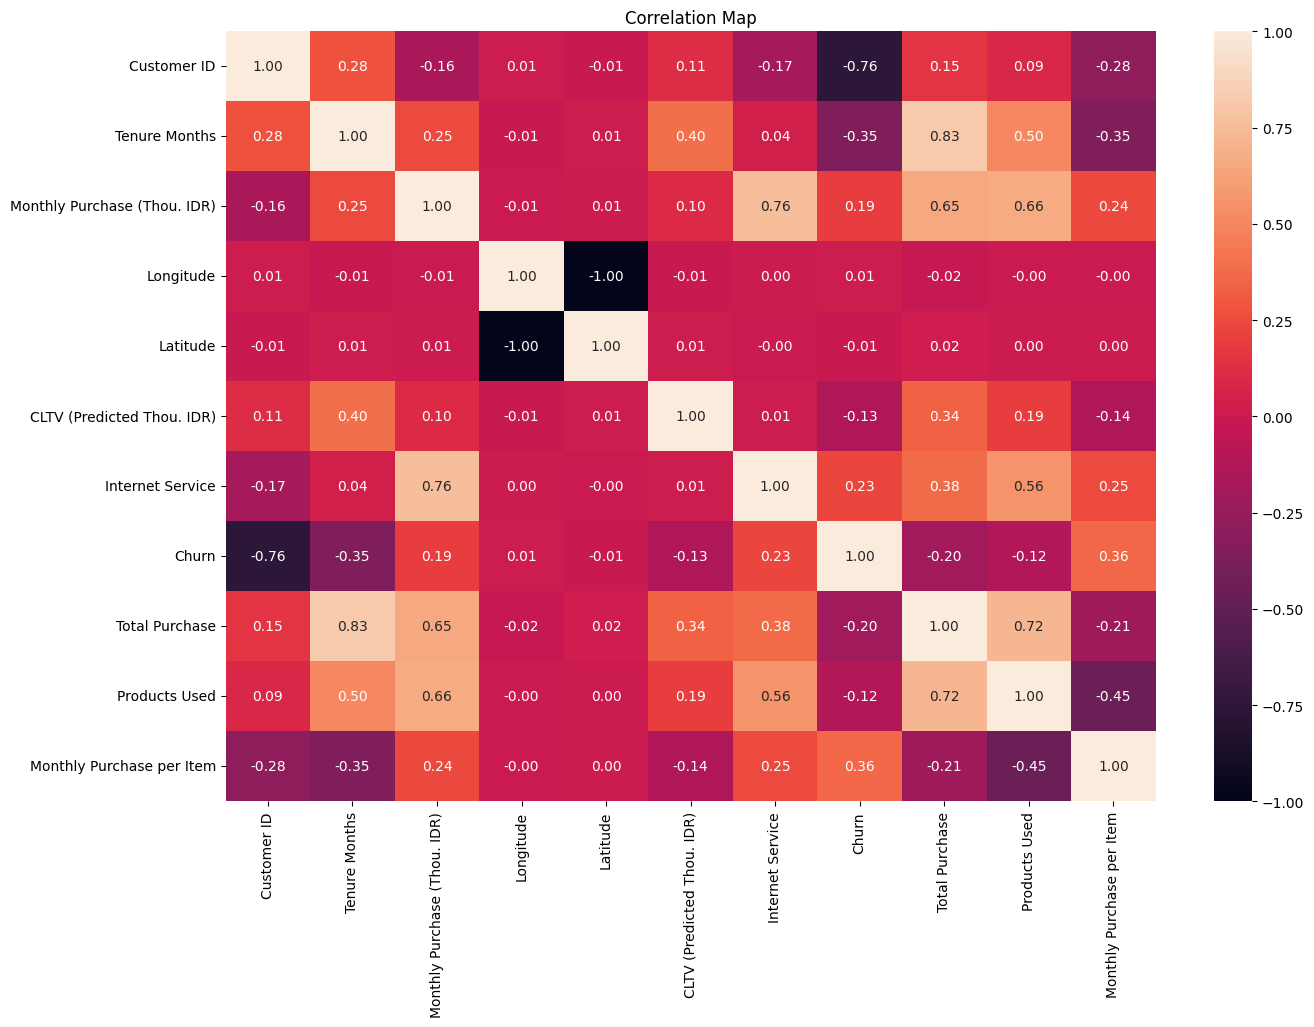

In [27]:
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [28]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

## Data Preparation

In [29]:
# Functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression

def baseline_data_preparation(data):
    """
        Prepare data
    """
    df = data.copy()

    # drop unimportant data
    df = df.drop(columns=["Customer ID"])

    # encoding
    device_class_map = {
        "High End": 3,
        "Mid End": 2,
        "Low End": 1
    }
    df["Device Class"] = df["Device Class"].replace(device_class_map)
    df['Churn Label'] = df['Churn Label'].replace({"Yes": "1", "No": "0"}).astype(int)

    # split data to train and test
    X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
    X = pd.get_dummies(X, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    return (X_train, X_test, y_train, y_test)

# calculate precision, recall, f1 score
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model
    """
    print(f"""
        METRICS
        Precision: {precision_score(y_true, y_pred)}
        Recall: {recall_score(y_true, y_pred)}
        F1 Score: {f1_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC AUC score
    print(f"ROC AUC score: {roc_auc_score(y_true, y_pred)}")

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()
    

def baseline_model(X_train, y_train, X_val, y_val):
    """
       Perform baseline model training and evaluate result 
    """
    model = LogisticRegression(random_state=42, max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    evaluate(model, y_val, y_pred, y_pred_proba)

    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.show()

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
# Cross Validation
# ========================================

# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = baseline_data_preparation(df_ori)

# create pipeline
# ========================================
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=200))

# perform cross validation
# ========================================
cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
display(score, f"Score Mean: {score.mean()}")

array([0.58479532, 0.60147601, 0.5630713 , 0.60682226, 0.55705996])

'Score Mean: 0.5826449715640756'

## Baseline Model 


        METRICS
        Precision: 0.6397306397306397
        Recall: 0.5080213903743316
        F1 Score: 0.5663189269746647
    


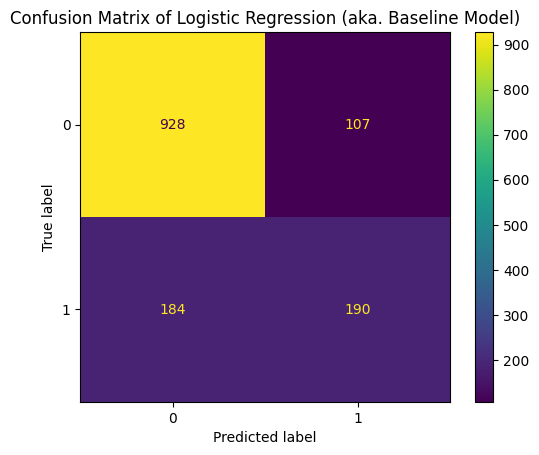

ROC AUC score: 0.7023198739311272


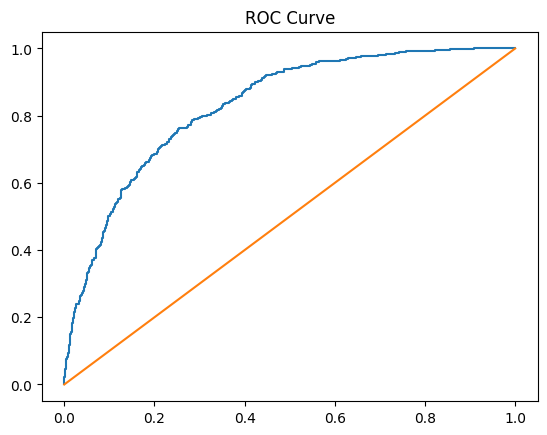

c:\Users\USER\anaconda3\envs\ml-tools\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


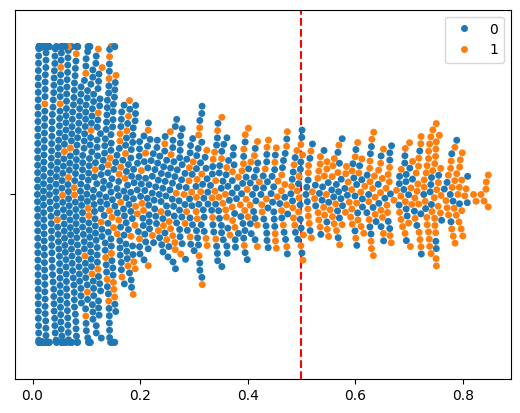

In [31]:
# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = baseline_data_preparation(df_ori)

# scaling
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
baseline_model(X_train, y_train, scaler.transform(X_test), y_test)

1. For churn we would focus on `precision` because we want to identify as much as customer that wanted to churn as possible bcause there's nothing wrong with applying retentioin campaign to customers that don't churn.
2. `ROC AUC score` is also important that because that determines how well our model in **discriminate** customers who churn and not.
3. Swarm plot labels indicate that a lot of actual churn customers don't have a high probability of churn

## Model Improvement

### 1. Feature Engineering

In [32]:
# Functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression

def data_preparation_feature_engineering(data):
    """
        Prepare data
    """
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1

    def uses_internet_for_product(data):
        if data == "Yes": return 1
        return 0
    
    # get data
    df = data.copy()

    # drop unimportant data
    df = df.drop(columns=["Customer ID", "Latitude", "Longitude"])

    # feature engineering
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
        .apply(lambda x: uses_internet_for_product(x['Games Product'])
            + uses_internet_for_product(x['Music Product'])
            + uses_internet_for_product(x['Education Product'])
            + uses_internet_for_product(x['Call Center'])
            + uses_internet_for_product(x['Use MyApp']), axis=1)
    df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)
    
    # encoding
    device_class_map = {
        "High End": 3,
        "Mid End": 2,
        "Low End": 1
    }
    df["Device Class"] = df["Device Class"].replace(device_class_map)
    df["Churn Label"] = df["Churn Label"].replace({"Yes": "1", "No": "0"}).astype(int)
    
    # split data to train and test
    X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
    X = pd.get_dummies(X, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    return (X_train, X_test, y_train, y_test)

# calculate precision, recall, f1 score
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model
    """
    print(f"""
        METRICS
        Precision: {precision_score(y_true, y_pred)}
        Recall: {recall_score(y_true, y_pred)}
        F1 Score: {f1_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC AUC score
    print(f"ROC AUC score: {roc_auc_score(y_true, y_pred)}")

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()
    

def baseline_model(X_train, y_train, X_val, y_val):
    """
       Perform baseline model training and evaluate result 
    """
    model = LogisticRegression(random_state=42, max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    evaluate(model, y_val, y_pred, y_pred_proba)

    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.show()

#### Cross Validation


In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
# Cross Validation
# ========================================

# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering(df_ori)

# create pipeline
# ========================================
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=200))

# perform cross validation
# ========================================
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
display(score, f"Score Mean: {score.mean()}")

array([0.5083612 , 0.53846154, 0.51170569, 0.56521739, 0.4916388 ,
       0.51505017, 0.56521739, 0.5083612 , 0.50167224, 0.52842809])

'Score Mean: 0.5234113712374582'

#### Baseline Model


        METRICS
        Precision: 0.6411960132890365
        Recall: 0.516042780748663
        F1 Score: 0.5718518518518518
    


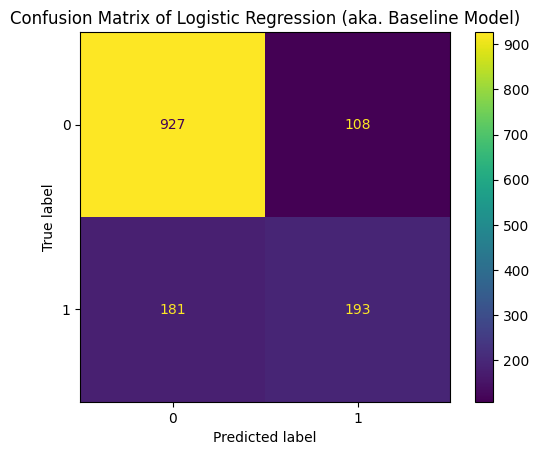

ROC AUC score: 0.7058474773308533


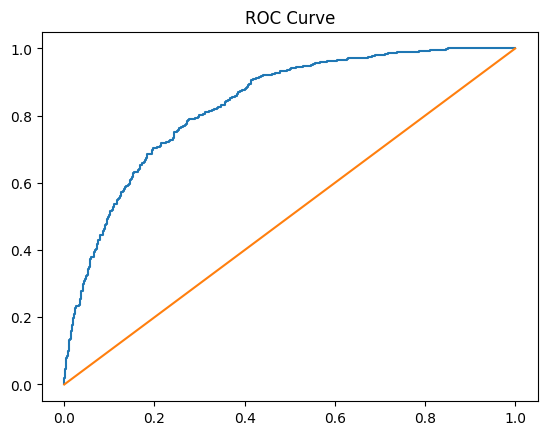

c:\Users\USER\anaconda3\envs\ml-tools\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


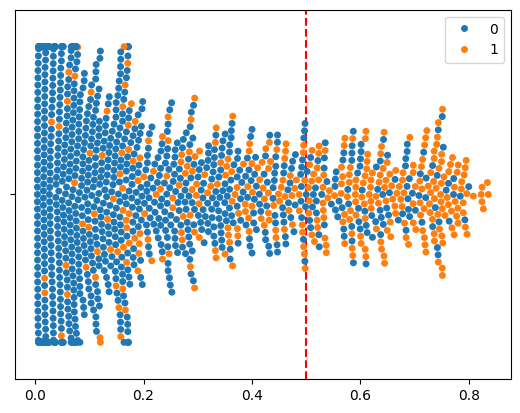

In [34]:
# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering(df_ori)

# scaling
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
baseline_model(X_train, y_train, scaler.transform(X_test), y_test)

### 2. Perform Oversampling
Oversampling is used to tackle imbalance class problem

In [35]:
# Functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression

def data_preparation_feature_engineering_smote(data):
    """
        Prepare data
    """
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1

    def uses_internet_for_product(data):
        if data == "Yes": return 1
        return 0
    
    # get data
    df = data.copy()

    # drop unimportant data
    df = df.drop(columns=["Customer ID"])

    # feature engineering
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
        .apply(lambda x: uses_internet_for_product(x['Games Product'])
            + uses_internet_for_product(x['Music Product'])
            + uses_internet_for_product(x['Education Product'])
            + uses_internet_for_product(x['Call Center'])
            + uses_internet_for_product(x['Use MyApp']), axis=1)
    df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)
    
    # encoding
    device_class_map = {
        "High End": 3,
        "Mid End": 2,
        "Low End": 1
    }
    df["Device Class"] = df["Device Class"].replace(device_class_map)
    df["Churn Label"] = df["Churn Label"].replace({"Yes": "1", "No": "0"}).astype(int)
    
    # split data to train and test
    X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
    X = pd.get_dummies(X, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversample train data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return (X_train, X_test, y_train, y_test)

# calculate precision, recall, f1 score
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model
    """
    print(f"""
        METRICS
        Precision: {precision_score(y_true, y_pred)}
        Recall: {recall_score(y_true, y_pred)}
        F1 Score: {f1_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC AUC score
    print(f"ROC AUC score: {roc_auc_score(y_true, y_pred)}")

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()
    

def baseline_model(X_train, y_train, X_val, y_val):
    """
       Perform baseline model training and evaluate result 
    """
    model = LogisticRegression(random_state=42, max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    evaluate(model, y_val, y_pred, y_pred_proba)

    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.show()

In [36]:
# from imblearn.over_sampling import SMOTE
# # change label of product and app
# df = df_ori.copy()
# def check_internet_service(row): 
#     if row['Games Product'] == "No internet service"\
#         and row['Music Product'] == "No internet service"\
#         and row['Education Product'] == "No internet service"\
#         and row['Video Product'] == "No internet service"\
#         and row['Use MyApp'] == "No internet service":
#         return 0
#     else: return 1

# def uses_internet_for_product(data):
#     if data == "Yes": return 1
#     return 0

# # change label of product and app
# df = df_ori.copy()

# # drop data
# df = df.drop(columns=["Customer ID", "Longitude", "Latitude"])

# # generate new features    
# df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
# df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
# # df["ProductsUsed"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
# #     .apply(lambda x: uses_internet_for_product(x['Games Product'])
# #         + uses_internet_for_product(x['Music Product'])
# #         + uses_internet_for_product(x['Education Product'])
# #         + uses_internet_for_product(x['Call Center'])
# #         + uses_internet_for_product(x['Use MyApp']), axis=1)
# df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

# # Encoding
# df['Churn Label'] = df['Churn Label'].replace({"Yes": "1", "No": "0"}).astype(int)

# # Ordinal encoding
# device_class_map = {
#     "High End": 3,
#     "Mid End": 2,
#     "Low End": 1
# }
# df["Device Class"] = df["Device Class"].replace(device_class_map)

# # One hot encoding
# df = pd.get_dummies(df, columns=['Payment Method', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp', 'Location', 'Call Center'], dtype=int)


# # split data to train and test
# X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val, shuffle=True)

# # Oversample train data
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# # scaling
# # scaler = StandardScaler()
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)

#### Cross Validation


In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
# Cross Validation
# ========================================

# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering_smote(df_ori)

# create pipeline
# ========================================
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=200))

# perform cross validation
# ========================================
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
display(score, f"Score Mean: {score.mean()}")

array([0.82729469, 0.80676329, 0.81763285, 0.84057971, 0.81642512,
       0.80676329, 0.8236715 , 0.82487923, 0.82004831, 0.8321256 ])

'Score Mean: 0.8216183574879228'

#### Baseline Model


        METRICS
        Precision: 0.6300940438871473
        Recall: 0.5374331550802139
        F1 Score: 0.5800865800865801
    


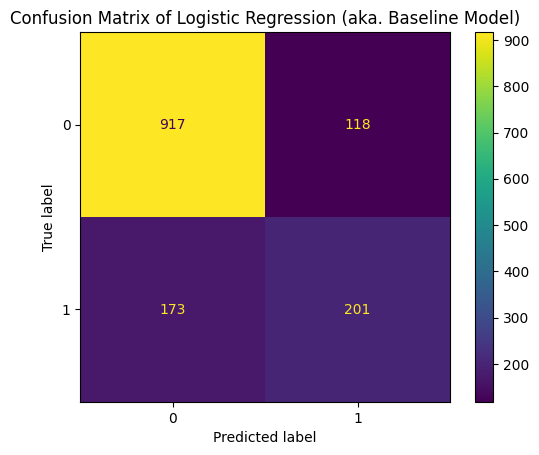

ROC AUC score: 0.7117117466222326


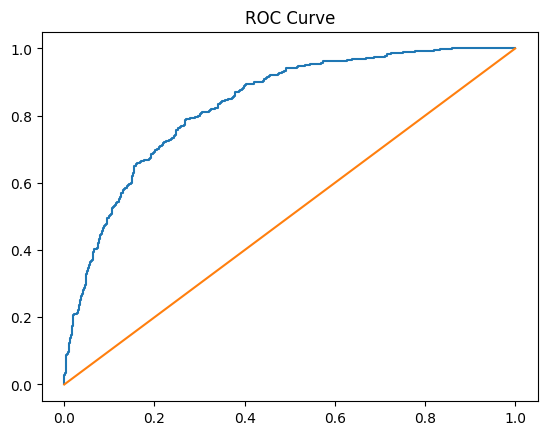

c:\Users\USER\anaconda3\envs\ml-tools\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


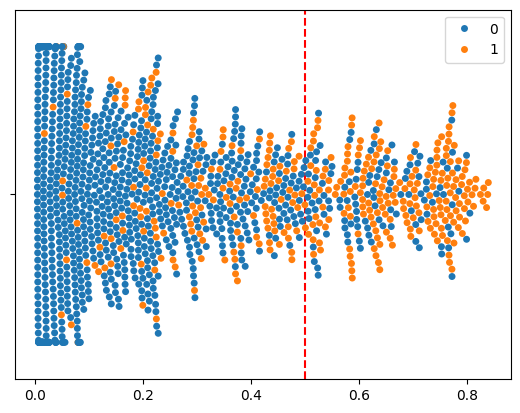

In [38]:
# prepare data
# ========================================
(X_train, X_test, y_train, y_test) = data_preparation_feature_engineering_smote(df_ori)
# X_val, X_test, y_val, y_test = train_test_split(
#     X_val, y_val, 
#     test_size=0.5, 
#     shuffle=True, 
#     stratify=y_val, 
#     random_state=42
# )

# scaling
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

baseline_model(X_train, y_train, scaler.transform(X_test), y_test)

### 3. Try Other Models

In [39]:
# # classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, f1_score

models = [
    LogisticRegression(random_state=42, max_iter=200), SVC(probability=True), KNeighborsClassifier(), 
    DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42), XGBClassifier(random_state=42),
    CatBoostClassifier(random_state=42), LGBMClassifier(objective='binary', random_state=42), ExtraTreesClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    # get data
    (X_train, X_test, y_train, y_test) = data_preparation_feature_engineering_smote(df_ori)
    
    # standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    # train
    model.fit(X_train, y_train)

    # predict
    y_pred_proba = model.predict_proba(scaler.transform(X_test))
    y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "Threshold": [threshold for _ in range(len(models))],
        "Recall": recalls,
        "Precisions": precisions,
        "F1 Score": f1s,
        "ROC AUC Score": roc_aucs,
    }
)

df_model

Learning rate set to 0.025403
0:	learn: 0.6781999	total: 146ms	remaining: 2m 25s
1:	learn: 0.6598544	total: 151ms	remaining: 1m 15s
2:	learn: 0.6432212	total: 155ms	remaining: 51.6s
3:	learn: 0.6276220	total: 160ms	remaining: 39.8s
4:	learn: 0.6134792	total: 164ms	remaining: 32.7s
5:	learn: 0.6000179	total: 169ms	remaining: 28s
6:	learn: 0.5878957	total: 174ms	remaining: 24.6s
7:	learn: 0.5712104	total: 178ms	remaining: 22.1s
8:	learn: 0.5602311	total: 183ms	remaining: 20.1s
9:	learn: 0.5486121	total: 187ms	remaining: 18.5s
10:	learn: 0.5392470	total: 193ms	remaining: 17.3s
11:	learn: 0.5305741	total: 198ms	remaining: 16.3s
12:	learn: 0.5205438	total: 203ms	remaining: 15.4s
13:	learn: 0.5084202	total: 207ms	remaining: 14.6s
14:	learn: 0.4975163	total: 213ms	remaining: 14s
15:	learn: 0.4920033	total: 218ms	remaining: 13.4s
16:	learn: 0.4834903	total: 222ms	remaining: 12.9s
17:	learn: 0.4790707	total: 228ms	remaining: 12.4s
18:	learn: 0.4728934	total: 232ms	remaining: 12s
19:	learn: 0.46

,Model Name,Threshold,Recall,Precisions,F1 Score,ROC AUC Score
0,LogisticRegression,0.5,0.537433,0.630094,0.580087,0.711712
1,SVC,0.5,0.491979,0.615385,0.546805,0.690434
2,KNeighborsClassifier,0.5,0.478610,0.552469,0.512894,0.669257
3,DecisionTreeClassifier,0.5,0.548128,0.491607,0.518331,0.671649
4,RandomForestClassifier,0.5,0.510695,0.585890,0.545714,0.690130
5,AdaBoostClassifier,0.5,0.577540,0.553846,0.565445,0.704712
6,GradientBoostingClassifier,0.5,0.580214,0.599448,0.589674,0.720059
7,XGBClassifier,0.5,0.537433,0.610942,0.571835,0.706881
8,CatBoostClassifier,0.5,0.566845,0.621701,0.593007,0.721104
9,LGBMClassifier,0.5,0.569519,0.622807,0.594972,0.722441


# LGBM Classifier (Best Model) Hyperparameter Tuning

In [40]:
def data_preparation_hp_lbgm(data):
    """
        Prepare data
    """
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1

    def uses_internet_for_product(data):
        if data == "Yes": return 1
        return 0
    
    # get data
    df = data.copy()

    # drop unimportant data
    df = df.drop(columns=["Customer ID", "Latitude", "Longitude"])

    # feature engineering
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
        .apply(lambda x: uses_internet_for_product(x['Games Product'])
            + uses_internet_for_product(x['Music Product'])
            + uses_internet_for_product(x['Education Product'])
            + uses_internet_for_product(x['Call Center'])
            + uses_internet_for_product(x['Use MyApp']), axis=1)
    df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)
    
    # encoding
    device_class_map = {
        "High End": 3,
        "Mid End": 2,
        "Low End": 1
    }
    df["Device Class"] = df["Device Class"].replace(device_class_map)
    df["Churn Label"] = df["Churn Label"].replace({"Yes": "1", "No": "0"}).astype(int)
    
    # split data to train and test
    X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
    X = pd.get_dummies(X, dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

    # Oversample train data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [86]:
np.arange(0.5, 0.91, 0.1)

array([0.5, 0.6, 0.7, 0.8])

In [ ]:
hp.randint

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 3311, number of negative: 3311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1151
[LightGBM] [Info] Number of data points in the train set: 6622, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

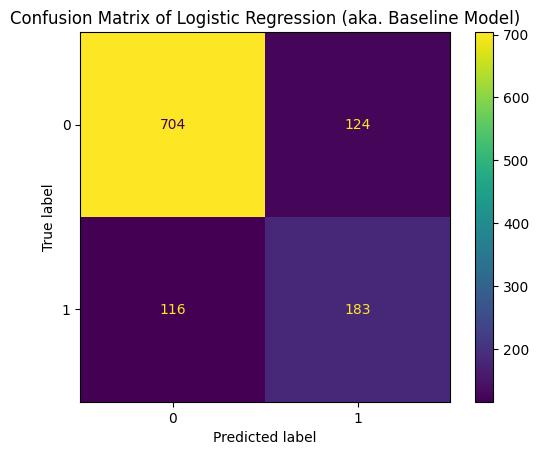

ROC AUC score: 0.731140839836492


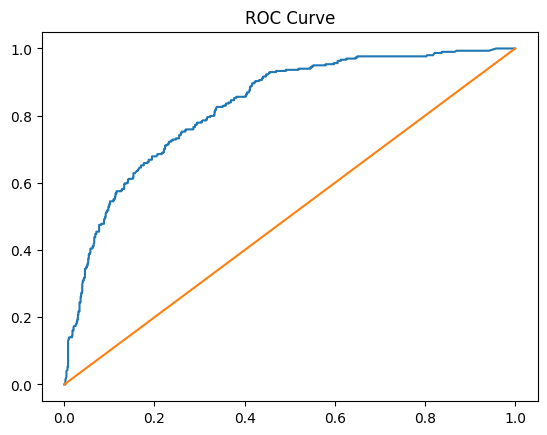

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8

        METRICS
        Precision: 0.5633802816901409
        Recall: 0.6417112299465241
        F1 Score: 0.6000000000000001
    


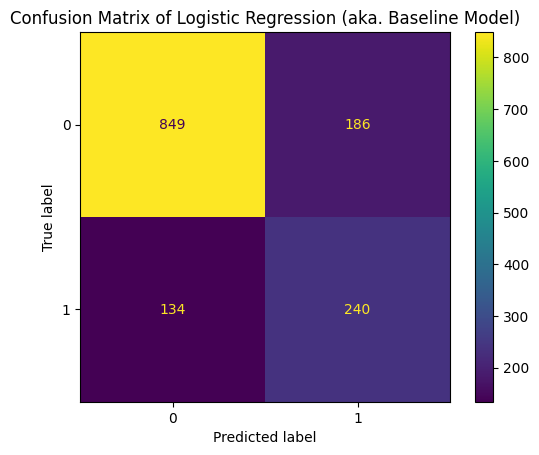

ROC AUC score: 0.7310005425094939


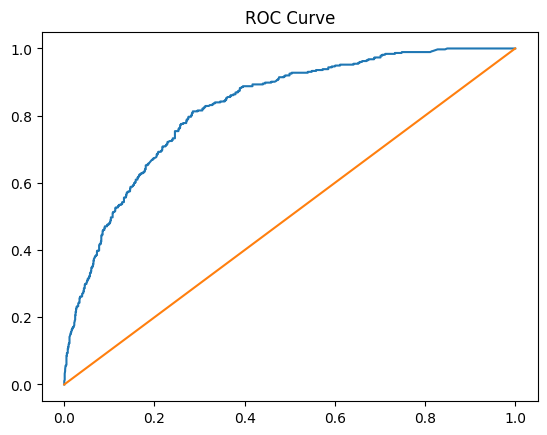

In [99]:
%reload_ext autoreload
%autoreload 2

from bayes_opt import BayesianOptimization
from hyperopt import hp, fmin, tpe
# prepare params
# SEARCH_PARAMS = {
#     "learning_rate": np.arange(0.01, 1.5, 0.01), # learning rate
#     "max_depth": np.arange(5, 16), # determine max depth of tree construction
#     "num_leaves": np.arange(5, 11), # determine number of leaves
#     "feature_fraction": np.arange(0.6, 0.95, 0.1), # select % percent of total features
#     "subsample": np.arange(0.6, 0.95, 0.1), # randomly select data without resampling 
#     "n_estimators": np.arange(50, 300, 50)
# }

SEARCH_PARAMS = {
    "learning_rate": 0.001, # learning rate
    "max_depth": 15, # determine max depth of tree construction
    "num_leaves": 10, # determine number of leaves
    "feature_fraction": 0.8, # select % percent of total features
    "subsample": 0.8, # randomly select data without resampling 
    "n_estimators": 2000
}


FIXED_PARAMS = {
    "objective": "binary", # specify model used for binary classification
    "metric": "auc", # metrics that will be used as objective function
    "is_unbalance": False, # whether it is unbalanced or balanced dataset
    "bagging_freq": 0.5, # enable bagging (bootstrap aggregation)
    "boosting": "dart", # boosting algorithm used
    "num_boost_round": 200, # number of iterations (boosting)
    "early_stopping": 20, # early stop of model to avoid overfitting    
}

# prepare data
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation_hp_lbgm(df_ori)

# scale data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# # convert to lightgbm dataset
# train_data = Dataset(X_train, y_train)
# val_data = Dataset(X_val, y_val)
# test_data = Dataset(X_test, y_test)

# training model
params = {
    "objective": FIXED_PARAMS["objective"], "metric": FIXED_PARAMS["metric"], "is_unbalance": FIXED_PARAMS["is_unbalance"],
    **SEARCH_PARAMS
}

model = LGBMClassifier(**params)
model.fit(X_train, y_train)
model.predict(scaler.transform(X_val))

# evaluate on validation set
threshold = 0.5
y_pred_proba = model.predict_proba(X_val)
y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
evaluate(model, y_val, y_pred, y_pred_proba)
# print(f"""
# ==========VALIDATION===========
# Recall: {recall_score(y_val, y_pred)}
# Precision: {precision_score(y_val, y_pred)}
# F1: {f1_score(y_val, y_pred)}
# ROC AUC: {roc_auc_score(y_val, y_pred)}
# """)



# evaluate on test set
threshold = 0.5
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
evaluate(model, y_test, y_pred, y_pred_proba)

# print(f"""
# ==========TEST===========
# Recall: {recall_score(y_test, y_pred)}
# Precision: {precision_score(y_test, y_pred)}
# F1: {f1_score(y_test, y_pred)}
# ROC AUC: {roc_auc_score(y_test, y_pred)}
# """)



